In [1]:
import SimpleITK as sitk
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import random
random.seed(42)
import re

In [2]:
def show_image(img):
    img_arr = sitk.GetArrayFromImage(img)
    print(img_arr.shape)
    H,W,Z = img_arr.shape
    plt.figure()

    plt.subplot(131)
    plt.imshow(img_arr[H//2,:,:], cmap="gray")
    plt.axis("off")

    plt.subplot(132)
    plt.imshow(img_arr[:,W//2,:], cmap="gray")
    plt.axis("off")

    plt.subplot(133)
    plt.imshow(img_arr[:,:,Z//2], cmap="gray")
    plt.axis("off")
    plt.show()

In [3]:
def largest_connected_component(image):
    labeled_image = sitk.ConnectedComponent(image)
    
    # Calculate the sizes of the connected components
    statistics = sitk.LabelShapeStatisticsImageFilter()
    statistics.Execute(labeled_image)

    # Get the number of labels (connected components)
    num_labels = statistics.GetNumberOfLabels()

    # If no connected components are found, return the input image
    if num_labels == 0:
        return image

    # Find the label of the largest connected component (excluding the background)
    largest_label = max(statistics.GetLabels(), key=lambda label: statistics.GetNumberOfPixels(label))

    # Create a binary mask for the largest connected component
    largest_component_mask = sitk.BinaryThreshold(labeled_image, lowerThreshold=largest_label, upperThreshold=largest_label)

    return largest_component_mask

In [4]:
def select_seed_point(image,mask):
    image_array = sitk.GetArrayViewFromImage(image)
    mask_array = sitk.GetArrayViewFromImage(mask)

    # Calculate the average intensity in the segmented area
    segmented_area_intensity = image_array[mask_array == 1]
    average_intensity = np.mean(segmented_area_intensity)
    # Get the points in the segmented area
    segmented_points = np.argwhere(mask_array == 1)

    # Calculate the intensity differences
    intensity_differences = np.abs(image_array[mask_array == 1] - average_intensity)

    # Calculate the center of mass of the segmented region
    center_of_mass = np.mean(segmented_points, axis=0)

    # Find the point with the minimum Euclidean distance to the center of mass and closest intensity to the average intensity
    euclidean_distances = np.linalg.norm(segmented_points - center_of_mass, axis=1)
    min_distance_index = np.argmin(euclidean_distances + intensity_differences)
    min_distance_point = segmented_points[min_distance_index]

    # Print the selected point
#     print("Selected point near the center of the segmented region (z, y, x):", list(min_distance_point))
    return [list(map(int, min_distance_point))]

In [5]:
def confidence_connected(image, mask):
    # Extract the centroid from the initial segmentation as the seed point
    mask = sitk.BinaryThreshold(mask, lowerThreshold=1, upperThreshold=255)

    seeds = select_seed_point(image, mask)

    # Apply Confidence Connected Region Growing
    confidence_connected_filter = sitk.ConfidenceConnectedImageFilter()
    confidence_connected_filter.SetInitialNeighborhoodRadius(1)  # You can adjust this parameter
    confidence_connected_filter.SetMultiplier(1.75)  # Confidence interval, you can adjust this parameter
    confidence_connected_filter.SetNumberOfIterations(10)  # You can adjust this parameter
    confidence_connected_filter.SetSeedList(seeds)
    confidence_connected_output = confidence_connected_filter.Execute(image)
    
    # Combine refined segmentation with the initial segmentation
    refined_segmentation = sitk.Or(mask, confidence_connected_output)
    
    return refined_segmentation


In [6]:
def rescale(image):
    lower_percentile = 5
    upper_percentile = 95
    lower = sitk.GetArrayViewFromImage(image).flatten().tolist()
    upper = sitk.GetArrayViewFromImage(image).flatten().tolist()
    lower = sorted(lower)[int(len(lower) * lower_percentile / 100)]
    upper = sorted(upper)[int(len(upper) * upper_percentile / 100)]
    rescaled_image = sitk.IntensityWindowing(image, lower, upper, 0, 255)
    
    return rescaled_image

In [7]:
def closing(mask, dilation_kernel=5, erosion_kernel=5):
    dilated_image = sitk.BinaryDilate(mask, (dilation_kernel,dilation_kernel,dilation_kernel))
    closed_image = sitk.BinaryErode(dilated_image, (erosion_kernel,erosion_kernel,erosion_kernel))
    
    return closed_image

In [8]:
def opening(mask, kernel_size):
    eroded_image = sitk.BinaryErode(mask, (kernel_size,kernel_size,kernel_size))
    opened_image = sitk.BinaryDilate(eroded_image, (kernel_size,kernel_size,kernel_size))
    
    return opened_image

In [9]:
def hausdorff_distance(ground_truth, mask):
    
    hausdorff_filter = sitk.HausdorffDistanceImageFilter()
    hausdorff_filter.Execute(ground_truth, mask)
    return hausdorff_filter.GetHausdorffDistance()

In [10]:
def dice_coefficient(ground_truth, mask):

    overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
    overlap_measures_filter.Execute(ground_truth, mask)
    return overlap_measures_filter.GetDiceCoefficient()

In [11]:
def jaccard_index(ground_truth, mask):
    if not (isinstance(ground_truth, sitk.Image) and isinstance(mask, sitk.Image)):
        raise TypeError("Both ground_truth and mask must be SimpleITK Images.")
    # Instantiate the LabelOverlapMeasuresImageFilter
    overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
    # Execute the filter with the ground truth and predicted images
    overlap_measures_filter.Execute(ground_truth, mask)
    # Get the Jaccard index
    return overlap_measures_filter.GetJaccardCoefficient()

In [12]:
def precision(ground_truth, prediction):
    prediction = sitk.GetArrayFromImage(prediction)
    ground_truth = sitk.GetArrayFromImage(ground_truth)
    true_positive = np.sum(prediction * ground_truth)
    false_positive = np.sum(prediction) - true_positive
    return true_positive / (true_positive + false_positive)

def recall(ground_truth, prediction):
    prediction = sitk.GetArrayFromImage(prediction)
    ground_truth = sitk.GetArrayFromImage(ground_truth)
    true_positive = np.sum(prediction * ground_truth)
    false_negative = np.sum(ground_truth) - true_positive
    return true_positive / (true_positive + false_negative)

In [107]:
ground_truth = pd.read_csv("/home/mahsadibaji/LPBA40_ground_truth.csv")
masks = pd.read_csv("/home/mahsadibaji/LPBA40_pred_mask.csv")
images = pd.read_csv("/home/mahsadibaji/LPBA40_subject_list.csv")

In [109]:
import os

output_directory = "post-processed-results"
os.makedirs(output_directory, exist_ok=True)

intermediate_folders = ['CCA_1', 'closing_1', 'confidence_connected','opening','CCA_2','closing_2']
for folder in intermediate_folders:
    os.makedirs(os.path.join(output_directory, folder), exist_ok=True)

In [110]:
column_names = ['subject_id','Unet','CCA_1', 'closing_1', 'confidence_connected','opening','CCA_2','closing_2']
dice_results = pd.DataFrame(columns=column_names)
hd_results = pd.DataFrame(columns=column_names)
jaccard_results = pd.DataFrame(columns=column_names)
precision_results = pd.DataFrame(columns=column_names)
recall_results = pd.DataFrame(columns=column_names)

In [111]:
for image_path,label_path,mask_path in zip(images['filename'], ground_truth['filename'], masks['filename']):
    pattern = r"S\d+"
    sid = re.search(pattern, image_path).group()
    print(sid)

    label = sitk.ReadImage(label_path)
    label = sitk.Cast(label, sitk.sitkFloat32) / 255.0
    label = sitk.Cast(label, sitk.sitkUInt8)
    
    mask = sitk.ReadImage(mask_path)
    mask = sitk.Cast(mask, sitk.sitkUInt8)
    
    image = sitk.ReadImage(image_path)
    image = rescale(image)
    
    dice_dict = {'subject_id':sid}
    hd_dict = {'subject_id':sid}
    jac_dict = {'subject_id':sid}
    precision_dict = {'subject_id':sid}
    recall_dict = {'subject_id':sid}
    
    dice_score, hd_score, jac_score = dice_coefficient(label, mask), hausdorff_distance(label, mask), jaccard_index(label,mask)
    precision_score, recall_score = precision(label,mask), recall(label,mask)
    precision_dict['Unet'] = precision_score
    recall_dict['Unet'] = recall_score
    dice_dict['Unet'] = dice_score
    hd_dict['Unet'] = hd_score
    jac_dict['Unet'] = jac_score
    
    #Connected Component Analysis
    largest_component = largest_connected_component(mask)
    dice_score, hd_score, jac_score = dice_coefficient(label, largest_component), hausdorff_distance(label, largest_component), jaccard_index(label,largest_component)
    precision_score, recall_score = precision(label,largest_component), recall(label,largest_component)
    precision_dict['CCA_1'] = precision_score
    recall_dict['CCA_1'] = recall_score
    dice_dict['CCA_1'] = dice_score
    hd_dict['CCA_1'] = hd_score
    jac_dict['CCA_1'] = jac_score
    
    sitk.WriteImage(largest_component, os.path.join(output_directory, "CCA_1", f"{sid}.nii.gz"))
    
    #Closing
    closed_mask = closing(largest_component, dilation_kernel=2, erosion_kernel=2)
    
    dice_score, hd_score, jac_score = dice_coefficient(label, closed_mask), hausdorff_distance(label, closed_mask), jaccard_index(label,closed_mask)
    precision_score, recall_score = precision(label,closed_mask), recall(label,closed_mask)
    precision_dict['closing_1'] = precision_score
    recall_dict['closing_1'] = recall_score    
    dice_dict['closing_1'] = dice_score
    hd_dict['closing_1'] = hd_score
    jac_dict['closing_1'] = jac_score
    
    sitk.WriteImage(closed_mask, os.path.join(output_directory, "closing_1", f"{sid}.nii.gz"))
    
    #Confidence Connected
    conf_connected = confidence_connected(image, closed_mask)
    
    dice_score, hd_score, jac_score = dice_coefficient(label, conf_connected), hausdorff_distance(label, conf_connected), jaccard_index(label,conf_connected)
    precision_score, recall_score = precision(label,conf_connected), recall(label,conf_connected)
    precision_dict['confidence_connected'] = precision_score
    recall_dict['confidence_connected'] = recall_score    
    dice_dict['confidence_connected'] = dice_score
    hd_dict['confidence_connected'] = hd_score
    jac_dict['confidence_connected'] = jac_score
    
    sitk.WriteImage(conf_connected, os.path.join(output_directory, "confidence_connected", f"{sid}.nii.gz"))
    
    #Opening
    opened = opening(conf_connected,kernel_size=2)
    
    dice_score, hd_score, jac_score = dice_coefficient(label, opened), hausdorff_distance(label, opened), jaccard_index(label, opened)
    precision_score, recall_score = precision(label,opened), recall(label,opened)
    precision_dict['opening'] = precision_score
    recall_dict['opening'] = recall_score    
    dice_dict['opening'] = dice_score
    hd_dict['opening'] = hd_score
    jac_dict['opening'] = jac_score
#     
    sitk.WriteImage(opened, os.path.join(output_directory, "opening", f"{sid}.nii.gz"))
    
    #Connected Component Analysis
    lcc = largest_connected_component(opened)
    
    dice_score, hd_score, jac_score = dice_coefficient(label, lcc), hausdorff_distance(label, lcc), jaccard_index(label,lcc)
    precision_score, recall_score = precision(label,lcc), recall(label,lcc)
    precision_dict['CCA_2'] = precision_score
    recall_dict['CCA_2'] = recall_score    
    dice_dict['CCA_2'] = dice_score
    hd_dict['CCA_2'] = hd_score
    jac_dict['CCA_2'] = jac_score
    
    sitk.WriteImage(lcc, os.path.join(output_directory, "CCA_2", f"{sid}.nii.gz"))
    
    #Closing
    closed_mask2 = closing(lcc,dilation_kernel=3,erosion_kernel=3)
    
    dice_score, hd_score, jac_score = dice_coefficient(label, closed_mask2), hausdorff_distance(label, closed_mask2), jaccard_index(label,closed_mask2)
    precision_score, recall_score = precision(label,closed_mask2), recall(label,closed_mask2)
    precision_dict['closing_2'] = precision_score
    recall_dict['closing_2'] = recall_score     
    dice_dict['closing_2'] = dice_score
    hd_dict['closing_2'] = hd_score
    jac_dict['closing_2'] = jac_score
         
    sitk.WriteImage(closed_mask2, os.path.join(output_directory, "closing_2", f"{sid}.nii.gz"))   

    dice_results = dice_results.append(dice_dict, ignore_index=True)
    hd_results = hd_results.append(hd_dict, ignore_index=True)
    jaccard_results = jaccard_results.append(jac_dict, ignore_index=True)
    precision_results = precision_results.append(precision_dict, ignore_index=True)
    recall_results = recall_results.append(recall_dict, ignore_index=True)

S01
S02
S03
S04
S05
S06
S07
S08
S09
S10
S11
S12
S13
S14
S15
S16
S17
S18
S19
S20
S21
S22
S23
S24
S25
S26
S27
S28
S29
S30
S31
S32
S33
S34
S35
S36
S37
S38
S39
S40


In [25]:
dice_results.to_csv("dice.csv")
hd_results.to_csv("hd.csv")
jaccard_results.to_csv("jac.csv")
precision_results.to_csv("precision.csv")
recall_results.to_csv("recall.csv")

In [24]:
precision_results

,subject_id,Unet,CCA_1,closing_1,confidence_connected,opening,CCA_2,closing_2
0,S01,0.686465,0.967709,0.967384,0.564076,0.792126,0.966492,0.965795
1,S02,0.790841,0.932070,0.930927,0.929892,0.931651,0.931651,0.930780
2,S03,0.753209,0.955233,0.954568,0.954568,0.955059,0.955059,0.953912
3,S04,0.636340,0.971606,0.971496,0.639666,0.826468,0.971463,0.972222
4,S05,0.911775,0.961756,0.960861,0.590529,0.927119,0.965096,0.965139
5,S06,0.814599,0.951288,0.949615,0.949631,0.950133,0.950133,0.948521
6,S07,0.743703,0.973450,0.972718,0.973260,0.973142,0.973142,0.972488
7,S08,0.849694,0.968094,0.967760,0.968362,0.968293,0.968290,0.968081
8,S09,0.773788,0.975197,0.974173,0.974174,0.974547,0.974547,0.973566
9,S10,0.914088,0.972439,0.970913,0.972016,0.971672,0.971672,0.970673


In [67]:
jaccard_results

,subject_id,Unet,CCA_1,closing_1,confidence_connected,opening,CCA_2,closing_2
0,S01,0.633518,0.865714,0.867386,0.547626,0.747190,0.900162,0.906938
1,S02,0.772048,0.906075,0.906311,0.909375,0.908213,0.908213,0.908570
2,S03,0.733256,0.923367,0.924076,0.924079,0.924189,0.924189,0.923903
3,S04,0.446291,0.588755,0.591652,0.562201,0.629402,0.708089,0.739774
4,S05,0.737518,0.769880,0.771275,0.562057,0.834542,0.865188,0.886250
5,S06,0.769871,0.890846,0.890476,0.890774,0.890621,0.890621,0.890104
6,S07,0.674333,0.857928,0.859696,0.878276,0.861005,0.861005,0.862414
7,S08,0.739778,0.827938,0.830249,0.846935,0.832888,0.832806,0.835376
8,S09,0.713722,0.881677,0.883573,0.883590,0.882772,0.882772,0.884179
9,S10,0.715347,0.750519,0.751594,0.782103,0.759393,0.759393,0.763042


In [68]:
hd_results

,subject_id,Unet,CCA_1,closing_1,confidence_connected,opening,CCA_2,closing_2
0,S01,124.235980,24.309628,24.309628,91.801823,79.340274,14.742326,14.742326
1,S02,125.982429,14.814321,14.814321,21.202578,14.036399,14.036399,14.036399
2,S03,124.336996,11.930954,11.930954,11.930954,11.930954,11.930954,11.930954
3,S04,118.203575,31.097260,31.097260,63.734116,63.412607,24.261887,24.261887
4,S05,101.834851,17.338231,17.338231,92.124814,88.914088,11.382081,11.382081
5,S06,119.329982,17.625360,17.625360,14.073468,17.895646,17.895646,17.895646
6,S07,121.578971,16.500000,16.500000,8.878878,16.328125,16.328125,16.328125
7,S08,104.869107,16.777969,16.777969,16.777969,16.777969,16.777969,16.777969
8,S09,117.718366,16.884040,16.884040,16.884040,16.884040,16.884040,16.884040
9,S10,104.201121,17.782760,17.782760,17.782760,17.782760,17.782760,17.782760


In [69]:
dice_results.describe()

,Unet,CCA_1,closing_1,confidence_connected,opening,CCA_2,closing_2
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.834849,0.916443,0.917338,0.872718,0.911744,0.923081,0.925069
std,0.053468,0.041127,0.040803,0.087285,0.041243,0.033904,0.033408
min,0.617152,0.741153,0.743444,0.695171,0.772556,0.829101,0.839119
25%,0.812755,0.903331,0.904923,0.804682,0.890686,0.904989,0.905882
50%,0.845278,0.929116,0.930308,0.904224,0.925870,0.936686,0.938846
75%,0.870321,0.939576,0.940511,0.938776,0.942502,0.946793,0.947961
max,0.906344,0.960157,0.960540,0.960542,0.960601,0.960601,0.960446


In [70]:
jaccard_results.describe()

,Unet,CCA_1,closing_1,confidence_connected,opening,CCA_2,closing_2
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.719803,0.848180,0.849675,0.783997,0.840274,0.858883,0.862278
std,0.073718,0.065200,0.064806,0.130213,0.066961,0.056502,0.055944
min,0.446291,0.588755,0.591652,0.532768,0.629402,0.708089,0.722829
25%,0.684594,0.823704,0.826356,0.673918,0.802916,0.826466,0.827957
50%,0.732019,0.867618,0.869699,0.825192,0.861973,0.880912,0.884741
75%,0.770415,0.886038,0.887703,0.884617,0.891257,0.898962,0.901073
max,0.828729,0.923367,0.924076,0.924079,0.924189,0.924189,0.923903


In [72]:
hd_results.describe()

,Unet,CCA_1,closing_1,confidence_connected,opening,CCA_2,closing_2
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,119.029721,18.248405,18.247786,40.792444,36.913654,18.755302,18.753246
std,10.737411,3.861636,3.862182,32.994648,28.071468,10.425788,10.427154
min,97.804218,11.543153,11.543153,8.878878,11.930954,10.713601,10.713601
25%,107.502858,15.893150,15.893150,16.815124,16.857522,14.658182,14.658182
50%,121.374498,17.481796,17.481796,20.211706,19.567316,16.914012,16.914012
75%,127.394186,20.415170,20.415170,76.849049,64.790553,20.036409,20.036409
max,134.802476,31.097260,31.097260,96.279963,95.726087,77.747226,77.747226


In [99]:
def plot_centre_slices(img,mask, filename):
    print(f"plot_centre_slices, image shape = {img.shape}")
    print(f"plot_centre_slices, mask shape = {mask.shape}")
    # Train
    H, W, Z = img.shape
    plt.figure()
    plt.subplot(131)
    plt.tight_layout(pad=0.5)
    plt.imshow(img[H//2, :, :].T[::-1], cmap="gray")
    plt.imshow(mask[H//2, :, :].T[::-1],  alpha=0.4)
    plt.axis('off')
    plt.tight_layout(pad=0.5)
    plt.subplot(132)
    plt.tight_layout(pad=0.5)
    plt.imshow(img[:, W//2, :].T[::-1, ::-1], cmap="gray")
    plt.imshow(mask[:, W//2, :].T[::-1, ::-1],  alpha=0.4)
    plt.axis('off')
    plt.tight_layout(pad=0.5)
    plt.subplot(133)
    plt.tight_layout(pad=0.5)
    plt.imshow(img[:, :, Z//2].T, cmap="gray")
    plt.imshow(mask[:, :, Z//2].T,  alpha=0.4)
    plt.axis('off')
    plt.tight_layout(pad=0.5)
    # date = str(datetime.now()).replace(
    #     " ", "_").replace(":", "_").replace(".", "_")
    plt.savefig(filename + ".png")

    return

In [71]:
image_p = "/mnt/c/Users/mahsadibaji/Downloads/LPBA40/native_space/S04/S04.native.mri.nii.gz"
ground_truth_p = "/mnt/c/Users/mahsadibaji/Downloads/LPBA40/native_space/S04/S04.native.brain.mask_conv.nii.gz"
unet_p = "/mnt/c/Users/mahsadibaji/Downloads/LPBA40-results/S04.native.unet.mask.nii.gz"
cca1_img_p = "/home/mahsadibaji/post-processed-results/CCA_1/S04.nii.gz"
closing1_img_p = "/home/mahsadibaji/post-processed-results/closing_1/S04.nii.gz"
cc_img_p = "/home/mahsadibaji/post-processed-results/confidence_connected/S04.nii.gz"
opening_im_pg = "/home/mahsadibaji/post-processed-results/opening/S04.nii.gz"
closing2_img_p = "/home/mahsadibaji/post-processed-results/closing_2/S04.nii.gz"

In [75]:
image = nib.load(image_p).get_fdata()
ground_truth = nib.load(ground_truth_p).get_fdata()
unet_img = nib.load(unet_p).get_fdata()
cca1_img = nib.load(cca1_img_p).get_fdata()
closing1_img = nib.load(closing1_img_p).get_fdata()
cc_img = nib.load(cc_img_p).get_fdata()
opening_img = nib.load(opening_im_pg).get_fdata()
closing2_img = nib.load(closing2_img_p).get_fdata()

plot_centre_slices, image shape = (256, 124, 256)
plot_centre_slices, mask shape = (256, 124, 256)


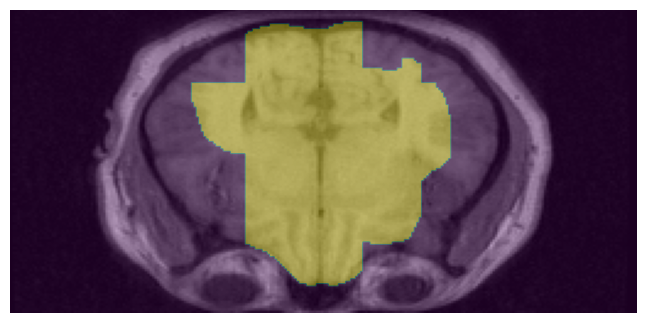

In [100]:
plot_centre_slices(image,unet_img,"unet")

plot_centre_slices, image shape = (256, 124, 256)
plot_centre_slices, mask shape = (256, 124, 256)


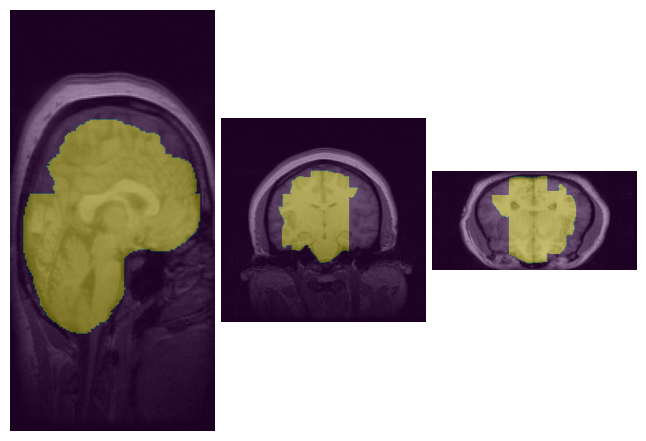

In [91]:
plot_centre_slices(image,cca1_img,"cca1")

plot_centre_slices, image shape = (256, 124, 256)
plot_centre_slices, mask shape = (256, 124, 256)


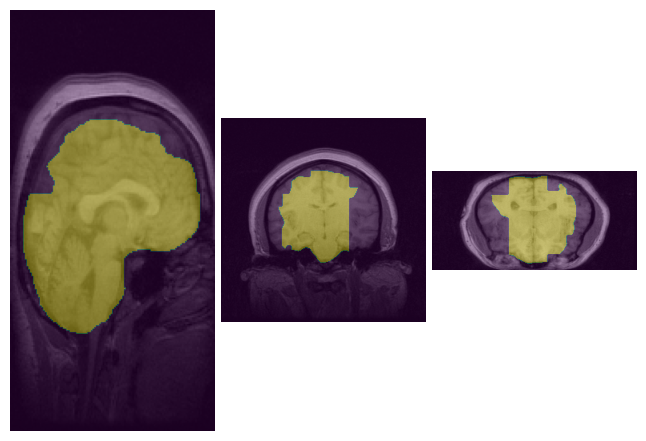

In [92]:
plot_centre_slices(image,closing1_img,"closing1")

plot_centre_slices, image shape = (256, 124, 256)
plot_centre_slices, mask shape = (256, 124, 256)


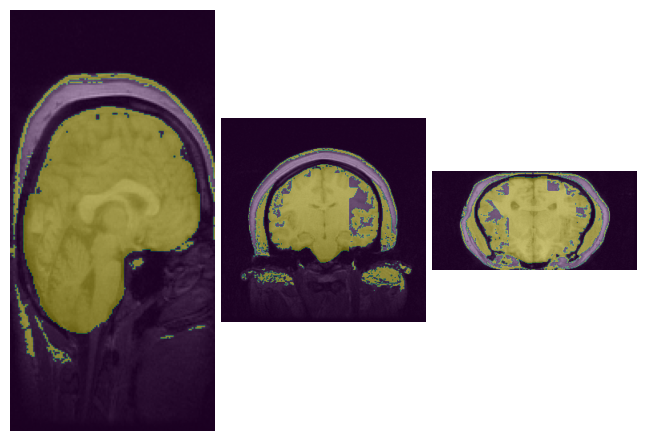

In [93]:
plot_centre_slices(image, cc_img, "cc")

plot_centre_slices, image shape = (256, 124, 256)
plot_centre_slices, mask shape = (256, 124, 256)


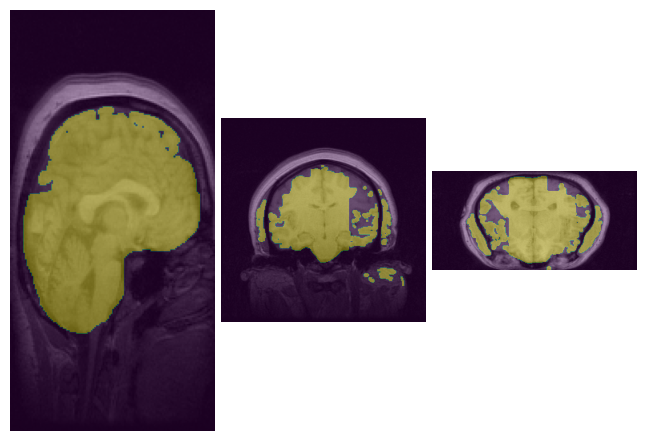

In [94]:
plot_centre_slices(image, opening_img,"opening")

plot_centre_slices, image shape = (256, 124, 256)
plot_centre_slices, mask shape = (256, 124, 256)


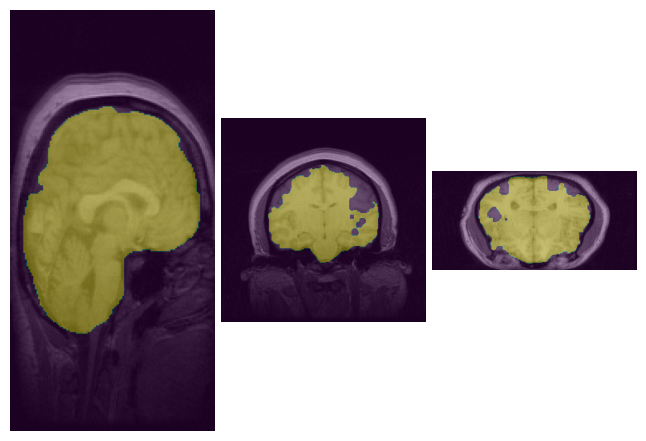

In [96]:
plot_centre_slices(image, closing2_img, "closing2")